In [ ]:
!pip install pennylane
!pip install autograd

# The qutip package is used to create the Bloch Sphere figures
!pip install qutip

In [2]:
import pennylane as qml                             
import matplotlib.pyplot as plt
import qutip as qp
from pennylane import numpy as np  
%matplotlib inline

In [3]:
# SPSA optimization class

class SPSA:
    
    def __init__( self, a=3 , c=0.01, A=0, α=0.602 , γ=0.101):
        self._a = a
        self._c = c
        self._A = A
        self._α = α
        self._γ = γ
        
    def step( self, function, θ, k ):
        
        ak = self._a/(k+self._A+1)**self._α, 
        ck = self._c/(k+1)**self._γ
                
        Δ  = 2*np.round( np.random.rand(θ.size).reshape(θ.shape) )-1
        
        θ_plus  = θ + ck*Δ
        θ_minus = θ - ck*Δ   
        
        function_plus  = function( θ_plus )  
        function_minus = function( θ_minus )  
        
        ghat = np.divide( function_plus-function_minus, 2*ck*Δ + 1e-8 )
        
        return θ - ak*ghat 

In [4]:
num_qubits = 1
opt = SPSA( a=2, c=0.1 )
max_iterations = 300

In [5]:
dev_an = qml.device("default.qubit", wires=num_qubits, analytic=True)
dev_st = qml.device("default.qubit", wires=num_qubits, analytic=False, shots = 1e7)

In [6]:
# Unknown state (|1>)

def Unknown_State(n_wires):
    qml.PauliX(wires = range(n_wires))

In [7]:
# Variational form for one qubit with an arbitrary rotation 

def Variational_circuit(params, n_wires):
    qml.broadcast( qml.Rot, wires= range(n_wires), pattern="single", parameters = params ) 

In [8]:
# Pauli Matrices

Paulis = np.zeros((3, 2, 2), dtype=complex)
Paulis[0] = [[0, 1], [1, 0]]
Paulis[1] = [[0, -1j], [1j, 0]]
Paulis[2] = [[1, 0], [0, -1]]

# Bloch vector function using the expectation values of the Pauli Matrices

def BlochVec(n_wires, params):
    bloch_vector = []
    for k in range(3):
        bloch_k = PauliExp(n_wires, params, A=Paulis[k])
        bloch_k = bloch_k.numpy()
        bloch_vector.append(bloch_k)
    return bloch_vector

In [9]:
# Analitic fidelity

@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    Unknown_State(n_wires)
    Variational_circuit(params, n_wires)
    return qml.probs(wires= range(n_wires))

# Pauli matrices expectation values

@qml.qnode(dev_an)
def PauliExp(n_wires, params, A=None):
    Variational_circuit(params, n_wires)
    # returns the expectation of the input matrix A
    return qml.expval(qml.Hermitian(A, wires = range(n_wires)))

# Stochastic fidelity

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    Unknown_State(n_wires)
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [10]:
#Initial parameters

params = 0.000001*np.ones((num_qubits, 3))

# Cost functions

fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

In [11]:
infids_an = []
infids_st = []
params_list = []


for n in range(max_iterations):
    params_list.append(params)
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'Final Fidelity = ', 1-infids_an[-1] )
print()

infids_an = np.array(infids_an)
infids_st = np.array(infids_st)


Final Fidelity =  0.9999999994689763



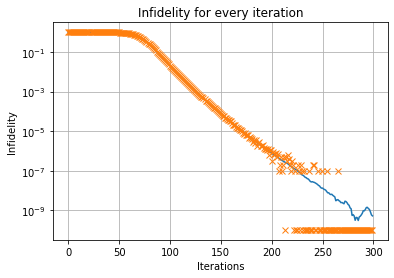

In [21]:
plt.plot( infids_an , label='Analitic Result')
plt.yscale('log')
ylim = min( 0.01, plt.axis()[2] )
infids_st[infids_st<ylim] = ylim
plt.plot( infids_st , 'x', label='Stochastic Result')
plt.title('Infidelity for every iteration')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')
plt.grid()

In [13]:
# Bloch vector for every iteration

Vec_List = []

for i in range(len(params_list)):
  b_vec = BlochVec(num_qubits, params_list[i])
  Vec_List.append(b_vec)

In [14]:
# x,y,z components of the Bloch Vector for every iteration

x_vec = []
y_vec = []
z_vec = []


for i in range(len(Vec_List)):
  x = Vec_List[i][0]
  y = Vec_List[i][1]
  z = Vec_List[i][2]
  x_vec.append(x)
  y_vec.append(y)
  z_vec.append(z)

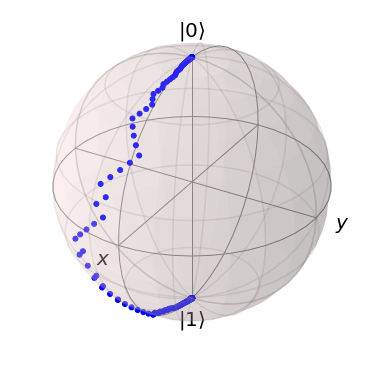

In [15]:
# Plotting on the Bloch sphere using qutip.Bloch class

b1 = qp.Bloch()
b1.add_points([x_vec, y_vec, z_vec])
b1.show()

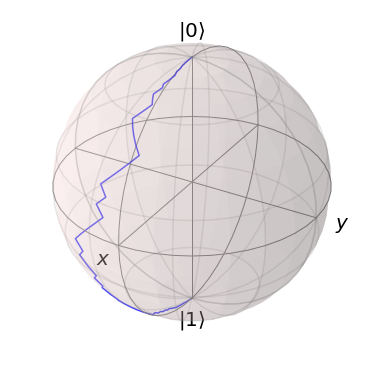

In [16]:
b2 = qp.Bloch()
b2.add_points([x_vec, y_vec, z_vec], meth='l')
b2.show()